# HW 3.3 (Penalized Regression) Solutions

In [172]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV

import matplotlib.pyplot as plt
import seaborn as sns

In [173]:
rets_sp500 = pd.read_excel('hw_3_3_data.xlsx', sheet_name=2, index_col=0)
rets_gld = pd.read_excel('hw_3_3_data.xlsx', sheet_name=3, index_col=0)[['GLD']]

### 1)

a.

In [174]:
ols_model = sm.OLS(rets_gld, sm.add_constant(rets_sp500)).fit()

# Coefficients
coef_ols = ols_model.params[1:].to_frame('Beta')
coef_ols

,Beta
A,0.065344
AAP,-0.030014
AAPL,-0.089102
ABC,-0.042315
ABT,0.075335
...,...
XYL,0.028848
YUM,-0.011571
ZBH,0.005700
ZBRA,0.054676


b.

In [175]:
# R-Squared
ols_model.rsquared

1.0

c.

In [176]:
ols_model.params.loc[lambda x: x.abs().nlargest(5).index]

NEM     0.159891
XOM    -0.152576
PM      0.134019
USB     0.132334
MSFT   -0.132020
dtype: float64

d.

In [177]:
sigma_beta_ols = rets.std() * coef_ols['Beta']

sigma_beta_ols.loc[lambda x: x.abs().nlargest(5).index]

NEM    0.007798
UAL   -0.006702
XOM   -0.005969
PHM    0.005465
SPG    0.005242
dtype: float64

Scaling by $\sigma_j$ allows us to have a more useful comparison between regression coefficients. In doing so, we find the largest (in magnitude) of the coefficients, and thus the most influential regressor, is NEM. 

e.

In [178]:
# Excluding intercept
np.linalg.cond(rets_sp500.T @ rets_sp500)

8.842269813227102e+18

In [179]:
# Including intercept
np.linalg.cond(sm.add_constant(rets_sp500).T @ sm.add_constant(rets_sp500))

1.1396384163374816e+20

A large condition number should give us pause as it indicates that very small change in the inputs to our training data would yield very large changes in our model's fitted parameters. In the case of linear regression, a high condition number raises concerns about multicollinearity, which can easily distort both the interpretation of coefficients and their out-of-sample performance. The condition numbers produced here are extremely large.

2)

a.

In [180]:
model_Ridge = Ridge(alpha=0.5, fit_intercept=True).fit(rets_sp500, rets_gld)

coef_ridge = pd.DataFrame(data=model_Ridge.coef_.reshape(451), index=rets_sp500.columns, columns=['Beta'])
coef_ridge

,Beta
A,0.013014
AAP,-0.013048
AAPL,-0.005152
ABC,-0.005360
ABT,0.001704
...,...
XYL,0.004060
YUM,0.001713
ZBH,-0.005478
ZBRA,0.001794


b.

In [181]:
model_Ridge.score(rets_sp500, rets_gld)

0.7622443309155418

b.

In [182]:
sigma_beta_ridge = rets.std() * coef_ridge['Beta']

sigma_beta_ridge.loc[lambda x: x.abs().nlargest(5).index]

NEM     0.005137
FCX     0.002314
ENPH    0.002027
SCHW   -0.001656
RHI    -0.001149
dtype: float64

We find that NEM again seems to be most influential.

3)

a.

In [183]:
model_Lasso = Lasso(alpha=2e-5, fit_intercept=True).fit(rets_sp500, rets_gld)

coef_lasso = pd.DataFrame(data=model_Lasso.coef_.reshape(451), index=rets_sp500.columns, columns=['Beta'])
coef_lasso

,Beta
A,0.011062
AAP,-0.001673
AAPL,-0.000000
ABC,-0.001622
ABT,0.000000
...,...
XYL,0.000000
YUM,-0.000000
ZBH,-0.000000
ZBRA,-0.000000


b.

In [184]:
model_Lasso.score(rets_sp500, rets_gld)

0.7541466465557553

c.

In [185]:
sigma_beta_lasso = rets.std() * coef_lasso['Beta']

sigma_beta_lasso.loc[lambda x: x.abs().nlargest(5).index]

NEM     0.011329
SCHW   -0.002511
O       0.002376
RJF    -0.002057
SLB     0.001808
dtype: float64

NEM is the largest coefficient, and is significantly larger than even the second largest coefficient.

d.

In [186]:
(coef_lasso != 0).sum()[0]

75

4)

a.

<AxesSubplot:title={'center':'OLS Coefficients'}, ylabel='Frequency'>

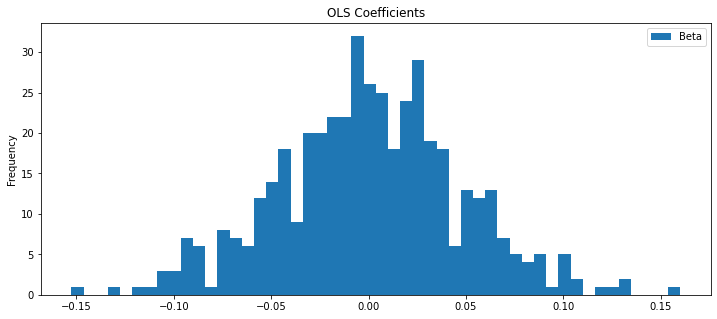

In [187]:
coef_ols.plot(kind='hist', bins=50, figsize=(12, 5), title='OLS Coefficients')

<AxesSubplot:title={'center':'Ridge Coefficients'}, ylabel='Frequency'>

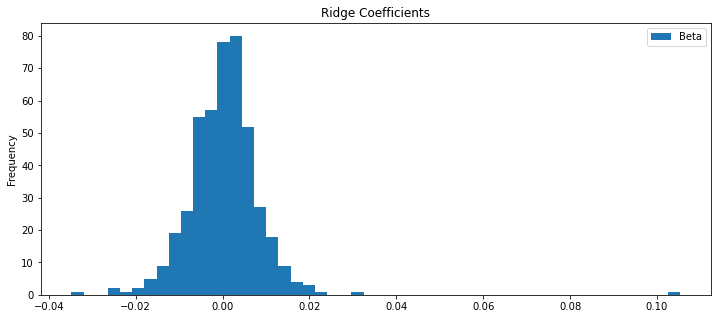

In [188]:
coef_ridge.plot(kind='hist', bins=50, figsize=(12, 5), title='Ridge Coefficients')

<AxesSubplot:title={'center':'Lasso Coefficients'}, ylabel='Frequency'>

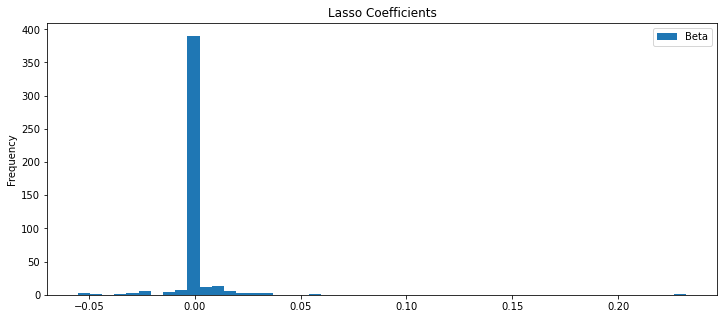

In [189]:
coef_lasso.plot(kind='hist', bins=50, figsize=(12, 5), title='Lasso Coefficients')

Immediately, it is quite clear that the penalized regressions (Lasso and Ridge) have notably smaller coefficients in general. It is also clear that the penalized regressions tend to push many coefficients towards 0, but some get pushed away from 0. This reflects the notion that the penalties serve to give more "responsibility" to certain regressors.

Unsurprisingly, all 3 models had coefficients distributed near 0, with Lasso having a significant proportion of them being equal to 0.

b.

From above, we found that OLS had the largest r-squared, which is entirely unsurprising given that this is referring to *in sample* performance. OLS was given far more "power" to fit the training data.

5)

In [190]:
model_ridge_cv = RidgeCV().fit(rets_sp500, np.ravel(rets_gld))

In [191]:
model_ridge_cv.alpha_

0.1

In [192]:
model_lasso_cv = LassoCV(max_iter=1e6).fit(rets_sp500, np.ravel(rets_gld))

In [193]:
model_lasso_cv.alpha_

4.555415661524658e-05

6)

In [194]:
train_X = rets_sp500.loc[:'2020']
train_y = rets_gld.loc[:'2020']

test_X = rets_sp500.loc['2021':]
test_y = rets_gld.loc['2021':]

In [195]:
ols_is = LinearRegression().fit(train_X, train_y)
ridge_is = Ridge(alpha=model_ridge_cv.alpha_).fit(train_X, train_y)
lasso_is = Lasso(alpha=model_lasso_cv.alpha_).fit(train_X, train_y)

In [196]:
# OLS OOS R-Squared
ols_is.score(test_X, test_y)

-0.5371417699641157

In [197]:
# Ridge OOS R-Squared
ridge_is.score(test_X, test_y)

0.3240521312484793

In [198]:
# Lasso OOS R-Squared
lasso_is.score(test_X, test_y)

0.4878444799760193

As demonstrated by the out of sample r-squared values, OLS performs far worse than does penalized regression. In fact, both Lasso and Ridge perform far better than the null model. Given more penalty values in our cross-validation for Ridge (instead of the default scikit-learn parameters), we may be better able to compare Lasso and Ridge. In general, however, it is important to remember that the "optimal" penalties found in part 5 were calculated using the test sample, which gives rise to some lookahead bias.